<a href="https://colab.research.google.com/github/cwerries/IANNWTF_Group_14_Submissions/blob/master/text_processing_incomplete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow-text
import matplotlib.pyplot as plt
import numpy as np
from numpy import dot
from numpy.linalg import norm
import string

import tensorflow as tf
from keras.preprocessing.sequence import skipgrams 
from keras.preprocessing import text
from tensorflow.keras import layers

In [2]:
import os
from google.colab import drive
drive._mount('/content/drive')
os.chdir('drive/MyDrive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocessing

Get most_common_words

In [3]:
def most_common_words(sentences): 
  tokenized = list(sum(sentences, []))
  count = {}
  for w in tokenized:
    count[w] = count.get(w, 0) + 1  # create dictionary of words with counts

  sorted_counts = dict(sorted(count.items(), key=lambda item: item[1], reverse=True))  #sort dictionary counts

  keys = [key for key in sorted_counts.keys()][:10000]   #get 10000 most common words

  return keys

Keep only processed sentence parts

In [4]:
import nltk 
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
with open('bible.txt') as f:
    file = f.readlines()

file = file[:5000]

sentences = []
for sentence in file:
  if sentence != "\n":
    sentence = sentence.translate(str.maketrans('', '', string.digits))
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    sentences.append(sentence.lower().split())

print("sentences: ", sentences[:2])

sentences = [[token for token in s if token not in stop_words] for s in sentences]
print("sentences: ", sentences[:2])

keys = most_common_words(sentences)
print("keys: ", keys[:5])

# sentences with only most common tokens
norm_bible = [[token for token in s if token in keys] for s in sentences]
print("norm_bible: ", norm_bible[:2])

norm_bible = [' '.join(tok_sent) for tok_sent in sentences]

sentences:  [['the', 'first', 'book', 'of', 'moses', 'called', 'genesis'], ['in', 'the', 'beginning', 'god', 'created', 'the', 'heaven', 'and', 'the', 'earth']]
sentences:  [['first', 'book', 'moses', 'called', 'genesis'], ['beginning', 'god', 'created', 'heaven', 'earth']]
keys:  ['unto', 'said', 'thou', 'thy', 'thee']
norm_bible:  [['first', 'book', 'moses', 'called', 'genesis'], ['beginning', 'god', 'created', 'heaven', 'earth']]


Assigning numeric identifiers to words -> create vocabulary of words with indices

In [30]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
vocab = tokenizer.word_index
inverse_vocab = {id:word for word, id in vocab.items()} #first index then word

vocab_size = len(vocab) + 1 # padding included
word_ids = [[vocab[id] for id in text.text_to_word_sequence(sent)] for sent in norm_bible]

print('Vocabulary Size: ', vocab_size)
print('Vocabulary Sample: ', list(vocab.items())[:5]) 
print("Sentences with word_ids: ", word_ids[:2])

Vocabulary Size:  2441
Vocabulary Sample:  [('unto', 1), ('said', 2), ('thou', 3), ('thy', 4), ('thee', 5)]
Sentences with word_ids:  [[186, 814, 172, 25, 1413], [583, 7, 300, 122, 19]]


In [31]:
# generate skip-grams
skip_grams = [skipgrams(w_id, vocabulary_size=vocab_size, window_size=4, negative_samples = 0.0) for w_id in word_ids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]

for i in range(5):
    print("({:s} ({:d}), {:s} ({:d}))".format(
          inverse_vocab[pairs[i][0]], pairs[i][0], 
          inverse_vocab[pairs[i][1]], pairs[i][1])) 

(genesis (1413), book (814))
(first (186), genesis (1413))
(genesis (1413), first (186))
(called (25), book (814))
(moses (172), book (814))


List of Skipgrams with word ids

In [32]:
# keep only word ids
list_pairs = []
for pair, _ in skip_grams:
  list_pairs.append(pair)

#flatten list
flat_list = []
for sublist in list_pairs:
  for item in sublist:
    if item[0] != item[1]:
      flat_list.append(item)

word_pairs_array = np.array(flat_list)
#print(word_pairs_array[:200])
# x = 0
# for pair in word_pairs_array:
#   if x <= 500:
#     print(inverse_vocab[pair[0]], inverse_vocab[pair[1]])
#     x += 1
    

Create tensor dataset

In [33]:
word_pairs_tensor =tf.data.Dataset.from_tensor_slices((word_pairs_array[:,0], word_pairs_array[:,1])) # create our data_set with inputs and targets
word_pairs_tensor = word_pairs_tensor.map(lambda word,embed: (word,tf.reshape(embed,(-1,)))) # the labels must have shape (batchsize,1) or the nce won't work later
prepared_ds = word_pairs_tensor.shuffle(1000).batch(32).prefetch(32)

# Model

In [34]:
class SkipGram(layers.Layer):
    def __init__(self, vocab_size, embedding_size):
        super(SkipGram, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size

        self.build("x")

    def build(self, input_shape):
      
      # self.weight_matrix = tf.Variable(tf.random.normal([self.vocab_size, self.embedding_size])) # we wnat the nce_weights to be randomly distributed at the start
      # self.score_bias = tf.Variable(tf.zeros([self.vocab_size])) # and the biases to be 0
      # self.emb_matrix = tf.Variable(tf.random.uniform([self.vocab_size, self.embedding_size])) # we choose a uniform random variable for the embedding matrix

      self.emb_matrix = self.add_weight(shape=(self.vocab_size, self.embedding_size), initializer='GlorotNormal')
      self.weight_matrix = self.add_weight(shape=(self.vocab_size, self.embedding_size), initializer='GlorotNormal')
      self.score_bias = self.add_weight(shape=(self.vocab_size), initializer='zeros')

    def call(self, input, labels):
        embeddings = tf.nn.embedding_lookup(self.emb_matrix, input)
        nce_loss = tf.nn.nce_loss(
            weights = self.weight_matrix,
            biases = self.score_bias,
            labels = labels,
            inputs = embeddings,
            num_sampled = 15,
            num_classes = self.vocab_size
            )
        loss = tf.reduce_mean(nce_loss)
        return loss

# Training

In [35]:
def nearest_neighbours(model, check_words):
  embeddings = model.emb_matrix.numpy()

  for word in check_words:
    word_id = vocab[word] # word ids of check_words

    cosine_sim = []
    #get closest word
    for i in range(len(embeddings)):
      cosine_sim.append(np.dot(embeddings[word_id], embeddings[i])/(norm(embeddings[word_id])*norm(embeddings[i])))

    nearest_neighbours = np.argsort(cosine_sim)[:1]
    print("To '", word,"' the nearest neighbour is: ", ",".join([inverse_vocab[n] for n in nearest_neighbours]))

In [36]:
tf.keras.backend.clear_session()

# define hyperparams
learning_rate = 0.01
num_epochs = 10
embedding_size = 64
k = 5

model = SkipGram(vocab_size, embedding_size)
optimizer = tf.optimizers.Adam(learning_rate)
#check_words= ["holy", "father", "wine", "poison", "love", "strong", "day" ]
check_words = ["moses", "book", "genesis", "earth", "heaven", "god", "spirit"]
losses = []

# We train for num_epochs epochs.
for epoch in range(num_epochs):

    epoch_loss_agg = []
    for input,target in prepared_ds:

      with tf.GradientTape() as tape:
        loss = model(input, target) # get the loss
      gradients = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))
      epoch_loss_agg.append(loss)
                   
    losses.append(tf.reduce_mean(epoch_loss_agg))
    
    print(f'Epoch: {str(epoch)} with loss {losses[-1]}')

    # after each epoch k nearest words
    nearest_neighbours(model, check_words)


Epoch: 0 with loss 15.112110137939453
To ' moses ' the nearest neighbour is:  carmi
To ' book ' the nearest neighbour is:  ashamed
To ' genesis ' the nearest neighbour is:  ashamed
To ' earth ' the nearest neighbour is:  ashamed
To ' heaven ' the nearest neighbour is:  ashamed
To ' god ' the nearest neighbour is:  renown
To ' spirit ' the nearest neighbour is:  renown
Epoch: 1 with loss 5.048102378845215
To ' moses ' the nearest neighbour is:  doer
To ' book ' the nearest neighbour is:  ashamed
To ' genesis ' the nearest neighbour is:  ashamed
To ' earth ' the nearest neighbour is:  ashamed
To ' heaven ' the nearest neighbour is:  ashamed
To ' god ' the nearest neighbour is:  doer
To ' spirit ' the nearest neighbour is:  ashamed
Epoch: 2 with loss 4.555867671966553
To ' moses ' the nearest neighbour is:  renown
To ' book ' the nearest neighbour is:  ashamed
To ' genesis ' the nearest neighbour is:  ashamed
To ' earth ' the nearest neighbour is:  bethlehem
To ' heaven ' the nearest neig

# Plot losses

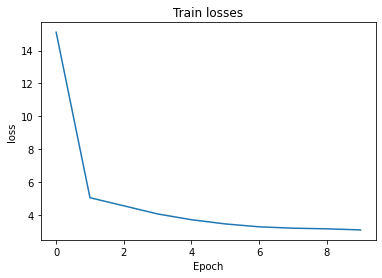

In [37]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(losses)
plt.title("Train losses")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.show()